NoteL
You need GPU


# Install Required Packages
*Use "pip install" to install the package*

In [ ]:
! pip install transformers==4.36.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [ ]:
! pip install torch==2.1.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.6 MB/s eta 0:00:00
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

# Load Python Libraries


In [ ]:
import gc
import os
import re
import time
import random
import datetime

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup


nltk.download('stopwords')
torch.cuda.empty_cache()
gc.collect()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# To make the run deterministic
SEED = 272419
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# tf.random.set_seed(SEED)

# Download Train and Test Dataset

In [ ]:
# download the data from https://github.com/MilaNLProc/translation_bias.git
! git clone https://github.com/MilaNLProc/translation_bias.git

Cloning into 'translation_bias'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 27 (delta 0), reused 27 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 3.95 MiB | 5.22 MiB/s, done.


# Load data

In [ ]:
LANG = "en_us" # can be replaced with "en_us"/"nl"/ "de"/"it"

# load .xlsx using pandas read_excel()
df_train = pd.read_excel("/content/translation_bias/data/"+LANG+"/"+LANG+"_TRAIN.xlsx")
df_test = pd.read_excel("/content/translation_bias/data/"+LANG+"/"+LANG+"_TEST.xlsx")

# view top 2 rows from the data
df_train.head(2)

,Unnamed: 0,text,age,age_cat,gender,label
0,263,prima snelle service iedereen aan te raden.,47,25-54,M,train
1,264,Bij Subside vond ik het Sunderland shirt waar ...,21,15-24,M,train


# Data Preparing

In [ ]:
# Drop duplicates and Nan data
print("Before dropping:")
print(len(df_train))
df_train.isnull().values.any()
df_train = df_train.drop_duplicates()
df_train = df_train[df_train['text'].notna()]

print("After dropping:")
print(len(df_train))

# drop unamed column
df_test.drop(["Unnamed: 0"], axis=1, inplace=True)
df_train.drop(["Unnamed: 0"], axis=1, inplace=True)

# renaming columns
df_train.rename(columns={'label': 'data_for','age_cat':'ageRange'}, inplace=True)
df_test.rename(columns={'label': 'data_for','age_cat':'ageRange'}, inplace=True)

# Convert the string labels to Categorical label
gender_label_map = {
    "F": 0,
    "M": 1
}

df_train["label"] = df_train['gender'].map(gender_label_map)
df_test["label"] = df_test['gender'].map(gender_label_map)

Before dropping:
5005
After dropping:
5005


# View train data

In [ ]:
df_train.head() #view top 5 rows
# df_train.tail() #view bottom 5 rows

,text,age,ageRange,gender,data_for,label
0,prima snelle service iedereen aan te raden.,47,25-54,M,train,1
1,Bij Subside vond ik het Sunderland shirt waar ...,21,15-24,M,train,1
2,Ik had per ongeluk 2 identieke bestellingen ge...,48,25-54,M,train,1
3,Altijd veel en leuke reclame's van vistaprint!...,20,15-24,M,train,1
4,Over het algemeen veel ervaring en hulp! Snell...,20,15-24,M,train,1


# Prepare data for training

In [ ]:
def get_text_and_label(df):

    X = df["text"].values
    y = df["label"].values
    return X, y


In [ ]:
X, y = get_text_and_label(df_train)

print(np.unique(y))
print(X.shape)
print(y.shape)

[0 1]
(5005,)
(5005,)


# Prepare the Model

# Set the model to use
To choose the model, uncomment one of the lines below

In [ ]:
print("LANGUAGE CHOSEN: ",LANG)

# FOR ENGLISH LANGUAGE
if LANG == "en_us":
    MODEL_NAME = "bert-base-uncased"
    # MODEL_NAME = "roberta-base"
    # MODEL_NAME = "xlnet-base-cased"

# FOR DUTCH LANGUAGE
if LANG == "nl":
    MODEL_NAME = 'GroNLP/bert-base-dutch-cased'
    # MODEL_NAME = "pdelobelle/robbert-v2-dutch-base"

# FOR GERMAN LANGUAGE
if LANG == "de":
    MODEL_NAME = 'dbmdz/bert-base-german-cased'
    # MODEL_NAME = "benjamin/roberta-base-wechsel-german"

# FOR ITALIAN LANGUAGE
if LANG == "it":
    MODEL_NAME = 'dbmdz/bert-base-italian-cased'
    # MODEL_NAME = "Musixmatch/umberto-commoncrawl-cased-v1""

print("MODEL_NAME for {0} Language: {1}".format(LANG,MODEL_NAME))


LANGUAGE CHOSEN:  nl
MODEL_NAME for nl Language: GroNLP/bert-base-dutch-cased


# Set the argument values for the model

In [ ]:
# Maximal length of input sequence
max_len = 512 #BERT model takes only 512 length

# Number of labels
NUM_LABELS = 2 # Label:Female and Male

# Specifying batch size: For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 8 # Use 8 or 16 to avoid CUDA memory error in Google Colab

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# Load Pretrained model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model for sequence classification, the pretrained model with a single linear classification layer on top.
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = NUM_LABELS,
    output_attentions = False,
    output_hidden_states = True,
)

# Tell pytorch to run this model on the GPU.
model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/254 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30073, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def tokenize(texts, tokenizer, max_len):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every text...
    for idx, text in enumerate(texts):
        encoded_dict = tokenizer.encode_plus(
            text,                      # Sentence to encode.
            add_special_tokens = True,
            padding = "max_length",
            truncation = True,
            max_length = max_len,
            return_attention_mask = True,
            return_tensors = 'pt')

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert to tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Prepare train and validation data

In [ ]:
input_ids, attention_masks = tokenize(texts=X, tokenizer=tokenizer, max_len=max_len)

labels = torch.tensor(y)

# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=1, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=1, test_size=0.2)

print("Shape of training and validation set:")
print(train_inputs.shape)
print(train_labels.shape)
print(validation_inputs.shape)
print(validation_labels.shape)

print("\nShape of attention masks:")
print(len(train_masks))
print(len(validation_masks))

Shape of training and validation set:
torch.Size([4004, 512])
torch.Size([4004])
torch.Size([1001, 512])
torch.Size([1001])

Shape of attention masks:
4004
1001


In [ ]:
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,   # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8   # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training vs. test
    # (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        # PyTorch doesn't do this automatically because accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    #token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)


    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    ### ----- Qi: add the following line to get detailed classification report -----
    eval_predictions, eval_true_labels = [], []
    ### END QI

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            #token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        ### ----- Qi: add the following line to get detailed classification report -----
        eval_predictions.append(logits)
        eval_true_labels.append(label_ids)
        ### END QI

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    ### ----- Qi: add the following line to get detailed classification report -----
    eval_flat_predictions = np.concatenate(eval_predictions, axis=0)
    eval_flat_predictions = np.argmax(eval_flat_predictions, axis=1).flatten()
    eval_flat_true_labels = np.concatenate(eval_true_labels, axis=0)
    ### END QI

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.8f}".format(eval_accuracy/nb_eval_steps))
    print("  Macro-F1: {0:.8f}".format(f1_score(eval_flat_true_labels, eval_flat_predictions, average="macro")))###
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...
  Batch    40  of    501.    Elapsed: 0:00:29.
  Batch    80  of    501.    Elapsed: 0:00:57.
  Batch   120  of    501.    Elapsed: 0:01:26.
  Batch   160  of    501.    Elapsed: 0:01:56.
  Batch   200  of    501.    Elapsed: 0:02:25.
  Batch   240  of    501.    Elapsed: 0:02:55.
  Batch   280  of    501.    Elapsed: 0:03:24.
  Batch   320  of    501.    Elapsed: 0:03:54.
  Batch   360  of    501.    Elapsed: 0:04:23.
  Batch   400  of    501.    Elapsed: 0:04:53.
  Batch   440  of    501.    Elapsed: 0:05:22.
  Batch   480  of    501.    Elapsed: 0:05:52.

  Average training loss: 0.67
  Training epoch took: 0:06:07

Running Validation...
  Accuracy: 0.59325397
  Macro-F1: 0.59655060
  Validation took: 0:00:33

Training complete!


# Test Model on test set

In [ ]:
# Get performance on test set
X_test, y_test = get_text_and_label(df_test)

print(np.unique(y_test))
print(X_test.shape)
print(y_test.shape)

[0 1]
(403,)
(403,)


In [ ]:
input_ids, attention_masks = tokenize(texts=X_test, tokenizer=tokenizer, max_len=max_len)
y_test = torch.tensor(y_test)

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, y_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids,
                        #token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 403 test sentences...
    DONE.


# Test Accuracy

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Print results:
accuracy = accuracy_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions, average="macro")

print("Accuracy:",  round(accuracy, 10))
print()

print("Macro-F1:", round(f1, 10))
print()


Accuracy: 0.6377171216

Macro-F1: 0.6363175592



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66       201
           1       0.66      0.57      0.61       202

    accuracy                           0.64       403
   macro avg       0.64      0.64      0.64       403
weighted avg       0.64      0.64      0.64       403



# Confusion Matrix Plot

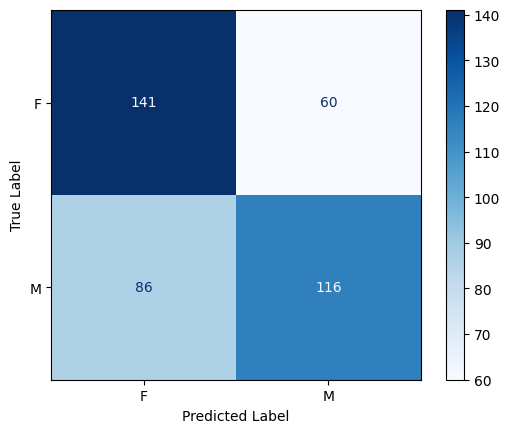

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def find_keys(value):
    return [key for key, x in gender_label_map.items() if x == value][0]

flat_true_labels_mapped = [find_keys(i) for i in flat_true_labels]
flat_predictions_mapped = [find_keys(i) for i in flat_predictions]
target_names = list(set(flat_true_labels_mapped))
conf_matrix = confusion_matrix(y_true=flat_true_labels_mapped, y_pred=flat_predictions_mapped)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
disp.ax_.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

# Save the prediction

In [ ]:
df_pred = pd.DataFrame({"label": flat_true_labels,
                        "text": X_test,
                        "predicted_label": flat_predictions})

if "/" in MODEL_NAME:
  str_MODEL_NAME = MODEL_NAME.replace("/", "_")
else:
  str_MODEL_NAME = MODEL_NAME
filename = "predicted_labels_testset_" + LANG+"_"+str_MODEL_NAME + ".csv"
print(filename)
df_pred.to_csv(filename,
               encoding="utf-8", index=False)

df_pred.head()

predicted_labels_testset_de_GroNLP_bert-base-dutch-cased.csv


,label,text,predicted_label
0,1,Bin wie immer mit Mindfactory sehr zufrieden. ...,1
1,0,Sehr schöner Baum,1
2,0,Die bestellte Lieferung war bereits nach 2 Tag...,1
3,1,Alles schnell gut Preise gut alles gut,1
4,1,Ich bin jetzt seit knapp 2 Jahren künde bei we...,0


# save the model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
if "/" in MODEL_NAME:
  str_MODEL_NAME = MODEL_NAME.replace("/", "_")
else:
  str_MODEL_NAME = MODEL_NAME
output_dir =  LANG+"_"+str_MODEL_NAME + "-genderclf"

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to de_GroNLP_bert-base-dutch-cased-genderclf


('de_GroNLP_bert-base-dutch-cased-genderclf/tokenizer_config.json',
 'de_GroNLP_bert-base-dutch-cased-genderclf/special_tokens_map.json',
 'de_GroNLP_bert-base-dutch-cased-genderclf/vocab.txt',
 'de_GroNLP_bert-base-dutch-cased-genderclf/added_tokens.json',
 'de_GroNLP_bert-base-dutch-cased-genderclf/tokenizer.json')